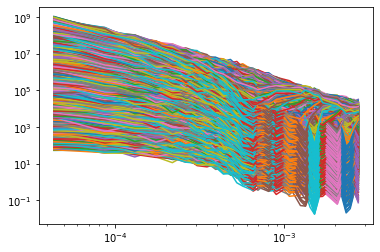

Total number of the simulated PSD profiles = 3600
||||||| Spliting the data (finished)-----------------
||||||| Data rescaled (finished)-----------------
||||||| Training/testing the machine (processing)-----------------
||||||| Training/testing the machine (finished)-----------------
Best parameters are {'max_depth': 26, 'n_estimators': 150}
Score = 0.9735489038880081
The best parameters are {'max_depth': 26, 'n_estimators': 150} with a score of 0.97


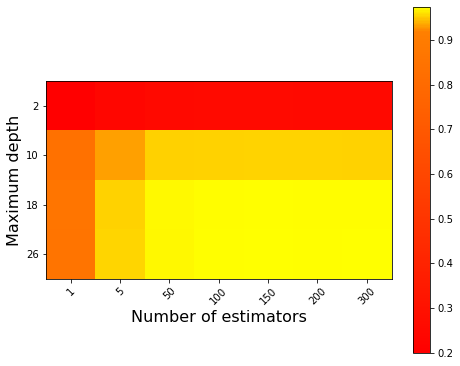

-----------------------------------------------------------------------------
Obs: /Users/phxpc/Desktop/RF/Data/0673580101_PN_source_powspec_300_1000eV_bin1.04.txt ===>> h = 16.90 rg
{'max_depth': 26, 'n_estimators': 150}
r2score (train/test) = 1.00 / 0.98
mse (train/test)     = 0.24 / 1.47


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
from scipy.fftpack import fft, ifft, fftshift
from scipy import interpolate
import math
import pandas as pd
import csv      # install this module if error occured.
import glob

######## Read all pre-produced 'response functions' stored in the directory ##########
######## 1st column is 'time (s)' ####################################################
######## 2nd column is 'Response' ####################################################

sh = '0023', '0040', '0060', '0080', '0100','0120','0140','0160','0180','0200','0220','0240','0260','0280', '0300'  # (real height * 100) as in the kynxilrev filename
h_label= [2.3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]    # labelled coronal height
re_frac = [0.6, 0.8, 1, 1.2, 1.4, 1.6]      # reflection fraction
se_t = 40                                   # number of the psd index to vary
PSD_index = np.linspace(0.5, 2.5, se_t)     # range of the psd index to vary
x = []
y = []

for ii in range(0, len(sh)) :
    globals()['resp_t'] = pd.read_csv('/Users/phxpc/Desktop/RF/Response/kynxilrev_100_45_%s_bands_lc.dat' % (sh[ii]), header = None, delim_whitespace=True, usecols=[0,1])
    label_height = sh[ii]
    int_label_height = int(label_height)
    #print(int_label_height)
    x.append(resp_t[0])
    y.append(resp_t[1])
    
############  Read the observed PSD file ############################################
############ 1st column is 'Frequency (Hz)' #########################################
############ 2nd column is 'Power' ##################################################

rootdir = '/Users/phxpc/Desktop/RF/Data'   
all_files = glob.glob(rootdir + "/*.txt")


#####################################################################################
################# Define important functions ########################################
#####################################################################################

def FT_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Fourier Transform with sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

       H(f) = \int h(t) exp(-2 \pi i f t) dt

    It returns f and H, which approximate H(f).

    Parametersb
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    H : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    Dt = t[1] - t[0]
    Df = 1. / (N * Dt)
    t0 = t[N // 2]

    f = Df * (np.arange(N) - N // 2)

    shape = np.ones(h.ndim, dtype=int)
    shape[axis] = N

    phase = np.ones(N)
    phase[1::2] = -1
    phase = phase.reshape(shape)

    if method == 1:
        H = Dt * fft(h * phase, axis=axis)
    else:
        H = Dt * fftshift(fft(h, axis=axis), axes=axis)

    H *= phase
    H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))
    H *= np.exp(-1j * np.pi * N / 2)

    return f, H

def PSD_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Power Spectral Density of sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

        H(f) = \int h(t) \exp(-2 \pi i f t) dt

    It returns f and PSD, which approximate PSD(f) where

    .. math::

        PSD(f) = |H(f)|^2 + |H(-f)|^2

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    PSD : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    ax = axis % h.ndim

    if method == 1:
        # use FT_continuous
        f, Hf = FT_continuous(t, h, axis)
        Hf = np.rollaxis(Hf, ax)
        f = -f[N // 2::-1]
        PSD = abs(Hf[N // 2::-1]) ** 2
        PSD[:-1] += abs(Hf[N // 2:]) ** 2
        PSD = np.rollaxis(PSD, 0, ax + 1)
    else:
        # A faster way to do it is with fftshift
        # take advantage of the fact that phases go away
        Dt = t[1] - t[0]
        Df = 1. / (N * Dt)
        f = Df * np.arange(N // 2 + 1)
        Hf = fft(h, axis=axis)
        Hf = np.rollaxis(Hf, ax)
        PSD = abs(Hf[:N // 2 + 1]) ** 2
        PSD[-1] = 0
        PSD[1:] += abs(Hf[N // 2:][::-1]) ** 2
        PSD[0] *= 2
        PSD = Dt ** 2 * np.rollaxis(PSD, 0, ax + 1)

    return f, PSD

def check_random_state(seed):
    """Turn seed into a np.random.RandomState instance

    If seed is None, return the RandomState singleton used by np.random.
    If seed is an int, return a new RandomState instance seeded with seed.
    If seed is already a RandomState instance, return it.
    Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, (int, np.integer)):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

def generate_power_law(N, dt, beta, generate_complex=False, random_state=None):
    """Generate a power-law light curve

    This uses the method from Timmer & Koenig [1]_

    Parameters
    ----------
    N : integer
        Number of equal-spaced time steps to generate
    dt : float
        Spacing between time-steps
    beta : float
        Power-law index.  The spectrum will be (1 / f)^beta
    generate_complex : boolean (optional)
        if True, generate a complex time series rather than a real time series
    random_state : None, int, or np.random.RandomState instance (optional)
        random seed or random number generator

    Returns
    -------
    x : ndarray
        the length-N

    References
    ----------
    .. [1] Timmer, J. & Koenig, M. On Generating Power Law Noise. A&A 300:707
    """
    random_state = check_random_state(random_state)
    dt = float(dt)
    N = int(N)

    Npos = int(N / 2)
    Nneg = int((N - 1) / 2)
    domega = (2 * np.pi / dt / N)

    if generate_complex:
        omega = domega * np.fft.ifftshift(np.arange(N) - int(N / 2))
    else:
        omega = domega * np.arange(Npos + 1)

    x_fft = np.zeros(len(omega), dtype=complex)
    x_fft.real[1:] = random_state.normal(0, 1, len(omega) - 1)
    x_fft.imag[1:] = random_state.normal(0, 1, len(omega) - 1)

    x_fft[1:] *= (1. / omega[1:]) ** (0.5*beta)
    x_fft[1:] *= (1. / np.sqrt(2))

    # by symmetry, the Nyquist frequency is real if x is real
    if (not generate_complex) and (N % 2 == 0):
        x_fft.imag[-1] = 0

    if generate_complex:
        x = np.fft.ifft(x_fft)
    else:
        x = np.fft.irfft(x_fft, N)

    return x

def bin_ndarray(ndarray, new_shape, operation):
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

##########################################################################################
##### re-dimension the array of the response so that each response has 8192 bins #########
##########################################################################################
x_redim = np.reshape(x, (len(sh), 8192)) 
y_redim = np.reshape(y, (len(sh), 8192))
setx = []
sety = []
yyy  = []
ttt  = []

###### Declare the model grid for the reflection fraction ######

for i in range(0, len(sh)):

        setx += [np.asarray(x_redim[i])]
        sety += [np.asarray(y_redim[i])]
        
        for j in range(len(re_frac)) :

            #area under response function
            area  = np.trapz(sety[i],setx[i])                
            yn    = (sety[i]/area)*re_frac[j]            
            arean = np.trapz(yn, setx[i])

            #delta function
            dx          = (setx[i][1])-(setx[i][0])
            deltax      = np.arange (0, (setx[i][0])+(3*dx), dx)
            deltay      = np.zeros(len(deltax))
            deltay[2]   = 1
            arx         = np.trapz(deltay, deltax)
            deltay      = (deltay/arx)*1

            #shift x-axis
            shiftx       = setx[i] + (3*dx)

            #mixarray
            ttt += [np.append(deltax, shiftx)]
            yyy += [np.append(deltay, yn)]
                           
tttx=[]
yyyy=[]
for data in ttt:
        tttx+=[data]

for data2 in yyy:
        yyyy+=[data2]
        
###################  make all bins to have the same size ############################
ttn,yyn=[],[]
for i in range(len(yyy)) :
    s, edges, _ = binned_statistic(tttx[i],yyyy[i], statistic='mean', bins=np.arange(0, 400005 , 5))
    for ggg in range(len(s)) :
        if  math.isnan(s[ggg]) == True :
            s[ggg]=s[ggg-1]
            # print('aor')
    #print("xxx")
    ttn+=[edges[:-1]]
    yyn+=[s]


# rebin #


new_bin_size = 40000 #new bin size

operation = 'mean'
ttn = np.asarray(ttn)
yyn = np.asarray(yyn)

ynew = bin_ndarray(yyn, new_shape=(90,new_bin_size), operation=operation)
tnew = bin_ndarray(ttn, new_shape=(90,new_bin_size), operation=operation)
#print(tnew.shape)

####################################################################################
######  Fourier tranform the respose functions #####################################
####################################################################################
ff,pp=[],[]
for j in range(0, len(yyn)):
    f, PSD = PSD_continuous(tnew[j], ynew[j], axis=-1, method=1)
    ff+=[f[1:-1]]
    pp+=[(PSD[1:-1])/PSD[1]]
#    plt.plot(ff[j],pp[j])
#    plt.xscale('log')

ffn,ppn=[],[]
for j in range(0, len(yyn)):
    fm=ff[j]/2 # freqency for 2*10^6 Msun   
    s, edges, _ = binned_statistic(fm, pp[j], statistic='mean',bins=np.arange(ff[j][0], ff[j][-1],  ff[j][2]-ff[j][1]))
    for ggg in range(len(s)) :
        if  math.isnan(s[ggg]) == True :
            s[ggg]=s[ggg-1]
    ffn+=[edges[:-1]]
    ppn+=[s]

f_obs= []
p_obs= []
##print(index)
for bb in range (0,se_t,1):
    for g in range(0, len(ppn)):
        p_p =[]
        p_p =  1/(2*np.pi*ffn[g])**PSD_index[bb] 
        p_obs +=[p_p*ppn[g]]
        f_obs +=[ffn[g]]
  
#for cc in range(0, len(p_obs)):
#    plt.plot(f_obs[cc],p_obs[cc])
#    plt.xscale('log')
#    plt.yscale('log')

p_obn=[]
random_state = np.random.RandomState(1)
for bb in range (0,se_t,1):
    for g in range(0, len(yyn)):
        p_p =[]
        dt=tnew[g][1]-tnew[g][0]
        t=dt * np.arange(new_bin_size)
        x =  generate_power_law(new_bin_size, dt, PSD_index[bb], random_state=random_state )
        f, p_p = PSD_continuous(t, x)
        p_obn +=[ (p_p[1:-3]*ppn[g])/((tnew[g][1]-tnew[g][0])**2) ]
        
#plt.plot(f_obs[3],p_obn[3])
#plt.plot(f_obs[3],p_obs[3])
#plt.xscale('log')
#plt.yscale('log')


# print(all_files)
x = []
y = []


f_x=[]
P_y=[]
for file in all_files:
    with open(file, 'r') as csvfile:
        plots = csv.reader(csvfile, delimiter='\t')     # tab is delimiter.
        x = []
        y = []
        for row in plots:
            x+=[float(row[0])]
            y+=[float(row[1])]
        f_x+=[x]
        P_y+=[y]




im=0     #number of flies in the directory <--- This is still needed to be 1 file in the directory
Pr=P_y[im]
fr=f_x[im]
for kk in range(36) : #loop for check minus bin#
    for i, j in zip( fr, Pr) :
        if j <=0 : 
            Pr.remove(np.array(j))
            fr.remove(np.array(i))


Pr=np.asarray(Pr)
fr=np.asarray(fr)

#new freqeuncy bin for data set# 
#append becuase algorithm will be cut last bin#
bin_f=bin_f=np.append( fr, fr[-1]+(fr[-1]-fr[-2]) )
p_obb=[]
f_obb=[]
for k in range(0, len(p_obn)):
    s1, edges1, _ = binned_statistic(f_obs[k], p_obn[k], statistic='mean', 
                                     bins=bin_f)
    for kkk in range(len(s1)) :
        if  math.isnan(s1[kkk]) == True :
            s1[kkk]=s1[kkk-1]


    f_obb+=[edges1[:-1]]
    p_obb+=[s1[:]]   
      
#plt.plot(f_obs[3],p_obn[3])
#plt.plot(f_obb[3],p_obb[3], marker="o")
#plt.xscale('log')
#plt.yscale('log')

for cc in range(0, len(p_obb)):
    plt.plot(f_obb[cc],p_obb[cc])
    plt.xscale('log')
    plt.yscale('log')

plt.show()    
    
rh_index=[]
height_index = []

for ww in range (len(h_label)) :
    for gg in range (len(re_frac)) :
        rh_index=np.append(rh_index, h_label[ww])
        
for hh in range (len(PSD_index)) :

    height_index = np.append(height_index, rh_index)
    
# for zz in range( 0 ,len(height_index) ) :
#         p_obb[zz]= np.append(p_obb[zz], height_index[zz])
        
print('Total number of the simulated PSD profiles =', len(height_index))

#label reflection frction#
rr_index=[]
reflx_index = []

for ww in range (len(h_label)) :
    rr_index = np.append(rr_index, re_frac)

for ii in range (len(PSD_index)) :
    reflx_index  = np.append(reflx_index, rr_index)

p_ob=[]
for kkk in p_obb :
    p_ob += [ kkk[:] ]

y_test=[]
for jjj in range (len(height_index))  :
    y_test+= [ np.append (reflx_index[jjj], height_index[jjj]) ]

p_ob = np.asarray(p_ob)
p_obs = np.asarray(p_obs)
y_test = np.asarray(y_test)


from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import np_version, parse_version
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler     
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import pickle

print('||||||| Spliting the data (finished)-----------------')

p_tr =[]
p_te =[]
y_tr =[]
y_te =[]
p_tr, p_te, y_tr, y_te = train_test_split(p_ob, y_test, train_size=0.8, random_state=40)

#Define features and labels
X_train0= []
X_test0= []
y_train=  []
y_test=  []
for ggg in p_tr :
    X_train0 += [ ggg[:] ]

for rrr in p_te :
    X_test0 += [ rrr[:] ]


X_train0 = np.asarray(X_train0)
X_test0 = np.asarray(X_test0)

for i in y_tr :
    y_train += [ i[-1] ]
for i in y_te :
    y_test += [ i[-1] ]

y_train = np.asarray(y_train )
y_test = np.asarray(y_test)

##############   re-scaled the data ###################

X_train = np.log10(X_train0)
X_test = np.log10(X_test0)
Pr = np.log10(Pr)
Pr = Pr.reshape(1, len(Pr))
print('||||||| Data rescaled (finished)-----------------')
print('||||||| Training/testing the machine (processing)-----------------')

##############   Hyperparameter tuning using GridSearchCV###################
md =  np.arange(2, 31, 8, 'int')           # maximum depth
n_e = [1, 5, 50, 100, 150, 200, 300]       # number of estimators

#   Train ML
param_grid = dict(max_depth=md, n_estimators=n_e)
grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print('||||||| Training/testing the machine (finished)-----------------')
para = grid.best_params_
print('Best parameters are', para)

score = grid.best_score_
print('Score =', score)

from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

scores = grid.cv_results_['mean_test_score'].reshape(len(md),
                                                     len(n_e))

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.autumn,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.ylabel('Maximum depth', fontsize=16)
plt.xlabel('Number of estimators', fontsize=16)

plt.colorbar()
plt.xticks(np.arange(len(n_e)), n_e, rotation=45)         
plt.yticks(np.arange(len(md)), md)
#plt.title('Validation accuracy')
plt.show()

y_pred_test=grid.predict(X_test)
y_pred_train=grid.predict(X_train)
r2score_train = r2_score(y_train,y_pred_train)
r2score_test = r2_score(y_test,y_pred_test)
mse_train=mean_squared_error(y_train,y_pred_train)
mse_test=mean_squared_error(y_test,y_pred_test)

############# Predict Oberved IRAS data ##############
Iras_t=grid.predict(Pr)

import os
print('-----------------------------------------------------------------------------')
print('Obs:', all_files[0], '===>> h =', format(Iras_t[0],".2f"), 'rg')
#print('Source height =', format(Iras_t[0],".2f"), 'r_g')
print("%s" % (grid.best_params_) )
print('r2score (train/test) =', format(r2score_train,".2f"), '/', format(r2score_test,".2f"))
print('mse (train/test)     =', format(mse_train,".2f"), '/', format(mse_test,".2f"))

